<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/UMAP%2BClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training LSTM Architecture with Best Params from Weight and Biases
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

## Loading of Stringer spontaneous data



In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [1]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []

for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [8]:
# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

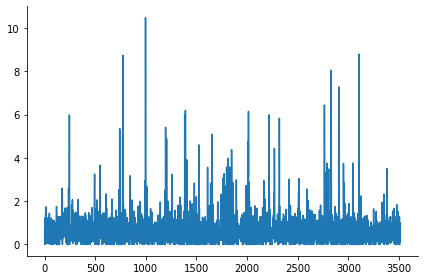

In [9]:
plt.plot(avgd_normed_dataRNN[0,:])

##  Clustering

In [15]:
!pip3 install umap-learn hdbscan --quiet

     |████████████████████████████████| 6.4 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [83]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split

In [82]:
a = np.zeros(1131)
b = np.ones(1131)
c = 2*b
d = 3*b
e = 4*b
f = 5*b
g = 6*b
h = 7*b
i = 8*b
labels = np.hstack((a,b, c, d,e, f, g, h, i))

In [87]:
X_train,  X_test, y_train, y_test = train_test_split(avgd_normed_dataRNN, labels, test_size = 0.20, random_state = 2021)

In [110]:
#factor = 6 
emb = umap.UMAP(random_state = 2021, n_components=2, n_neighbors= 45, min_dist = 0.3).fit(X_train, y = y_train)

In [111]:
test_embedding = emb.transform(X_test)

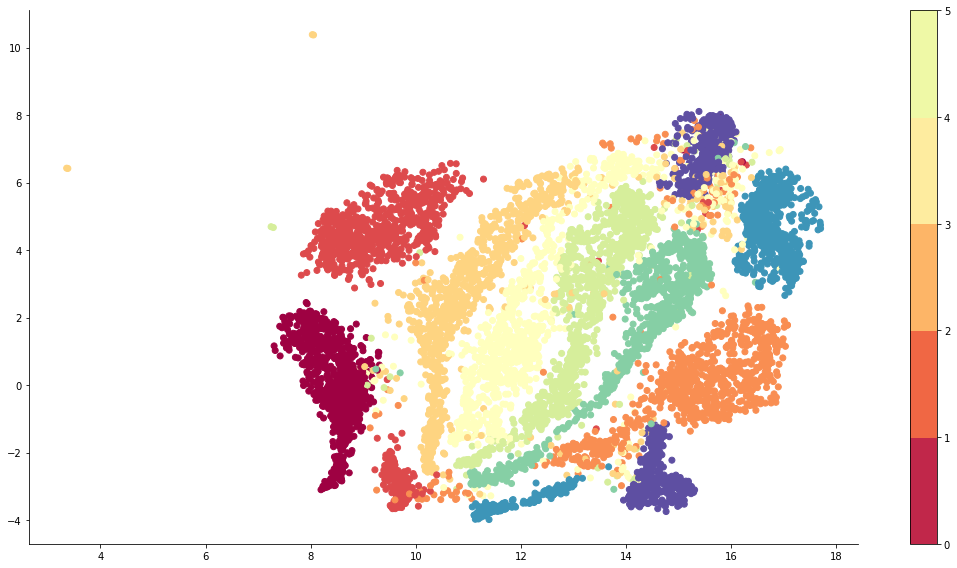

In [112]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*emb.embedding_.T,  c = y_train ,cmap = 'Spectral')
cbar = plt.colorbar(boundaries=np.arange(factor))
cbar.set_ticks(np.arange(factor))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

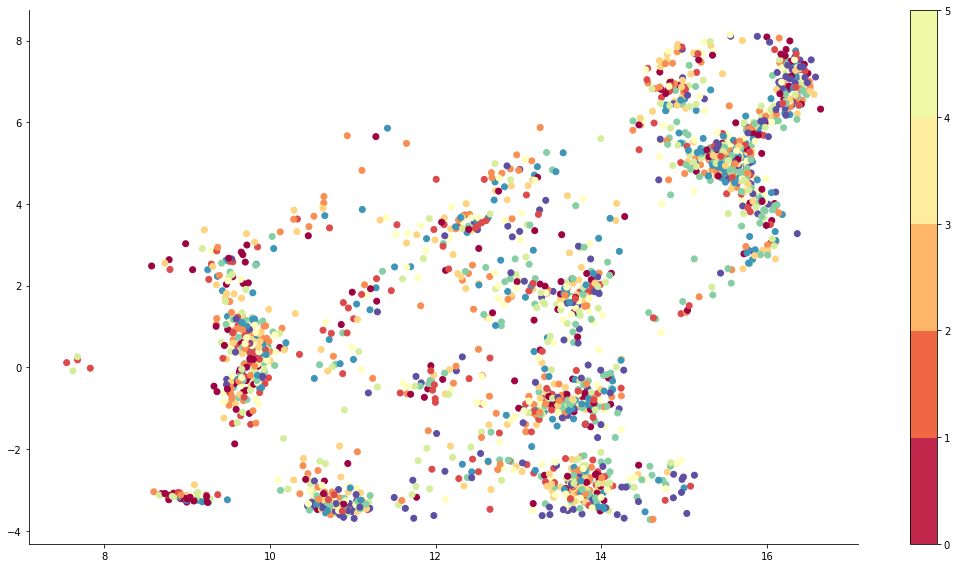

In [113]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*test_embedding.T,  c = y_test ,cmap = 'Spectral')
cbar = plt.colorbar(boundaries=np.arange(factor))
cbar.set_ticks(np.arange(factor))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [11]:
torch.__version__

'1.9.0+cu102'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [ ]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [ ]:
frac = 4/5
n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = 75#int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [ ]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.2,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr= 0.0003795, weight_decay= 10e-6)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[-0.0246],
          [-0.0236],
          [-0.0200],
          ...,
          [-0.0212],
          [-0.0207],
          [-0.0306]],
 
         [[-0.0641],
          [-0.0597],
          [-0.0608],
          ...,
          [-0.0718],
          [-0.0841],
          [-0.0718]],
 
         [[-0.1179],
          [-0.1076],
          [-0.1273],
          ...,
          [-0.1161],
          [-0.1150],
          [-0.1161]],
 
         ...,
 
         [[-0.0844],
          [-0.0664],
          [-0.0792],
          ...,
          [-0.0790],
          [-0.0817],
          [-0.0842]],
 
         [[-0.1031],
          [-0.0923],
          [-0.0826],
          ...,
          [-0.0868],
          [-0.0789],
          [-0.0952]],
 
         [[-0.0741],
          [-0.0754],
          [-0.0911],
          ...,
          [-0.0819],
          [-0.0836],
          [-0.0800]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[ 0.0639, -0.0152, -0.0546,  ...,  0.0009,  0.0238,  0.0009]],
 
 

# Training 9 Networks 
Training the same LSTM on the remaining layers

In [ ]:
from tqdm import tqdm 
from sam import SAM

In [ ]:
for run in tqdm(range(0, 9)):
    ### empty cuda at each iteration 
    torch.cuda.empty_cache()
    net = Net(ncomp, NN1, NN2, bidi = True).to(device)
    
    base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
    optimizer = SAM(net.parameters(), base_optimizer, lr=0.000375, weight_decay = 10e-6)#, momentum=0.9)

    # you can keep re-running this cell if you think the cost might decrease further
    cost = nn.MSELoss()
    
    x1_train = torch.from_numpy(avgd_normed_dataRNN[n_neurs*run:n_neurs*(run+1)  ,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
    x2_train = torch.from_numpy(avgd_normed_dataRNN[n_neurs*run:n_neurs*(run+1) ,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

    x1_valid = torch.from_numpy(avgd_normed_dataRNN[n_neurs*run:n_neurs*(run+1) ,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
    x2_valid = torch.from_numpy(avgd_normed_dataRNN[n_neurs*run:n_neurs*(run+1) ,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

    NN1 = x1_train.shape[0]
    NN2 = x2_train.shape[0]
    
    niter =  30000 # 
    # rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
    for k in tqdm(range(niter)):
        net.train()
        # the network outputs the single-neuron prediction and the latents
        z, y = net(x1_train)

        # our cost
        loss = cost(z, x2_train)

        # train the network as usual
        loss.backward()
        optimizer.first_step(zero_grad = True)
        cost(net(x1_train)[0],x2_train).backward()

        optimizer.second_step(zero_grad=True)

        """
        # this can be run in a first phase, before wandb finetuning
        with torch.no_grad():
            net.eval()
            train_save.append(loss.item())
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            valid_save.append(valid_loss.item())
        """;

        if k % 50 == 0:
            with torch.no_grad():
                net.eval()
                valid_loss = cost(net(x1_valid)[0], x2_valid)

                print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
                
    torch.save(net.state_dict, "/home/sazeglio/NMAs/SavedModels/Net_Layer_"+str(run)+".pt")

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "

  0%|          | 1/30000 [00:00<3:06:30,  2.68it/s]

 iteration 0, train cost 3.8251, valid cost 3.9055



  0%|          | 51/30000 [00:16<2:47:47,  2.97it/s]

 iteration 50, train cost 2.4887, valid cost 2.5416



  0%|          | 101/30000 [00:32<2:42:56,  3.06it/s]

 iteration 100, train cost 2.1957, valid cost 2.2638



  1%|          | 151/30000 [00:48<2:44:19,  3.03it/s]

 iteration 150, train cost 2.1787, valid cost 2.2471



  1%|          | 201/30000 [01:04<2:42:45,  3.05it/s]

 iteration 200, train cost 2.1754, valid cost 2.2449



  1%|          | 251/30000 [01:21<2:43:43,  3.03it/s]

 iteration 250, train cost 2.1739, valid cost 2.2443



  1%|          | 301/30000 [01:37<2:42:35,  3.04it/s]

 iteration 300, train cost 2.1716, valid cost 2.2433



  1%|          | 351/30000 [01:53<2:41:58,  3.05it/s]

 iteration 350, train cost 2.1693, valid cost 2.2418



  1%|▏         | 401/30000 [02:09<2:42:14,  3.04it/s]

 iteration 400, train cost 2.1659, valid cost 2.2388



  2%|▏         | 451/30000 [02:25<2:46:31,  2.96it/s]

 iteration 450, train cost 2.1595, valid cost 2.2322



  2%|▏         | 501/30000 [02:41<2:41:11,  3.05it/s]

 iteration 500, train cost 2.1437, valid cost 2.2150



  2%|▏         | 551/30000 [02:57<2:40:20,  3.06it/s]

 iteration 550, train cost 2.1103, valid cost 2.1772



  2%|▏         | 601/30000 [03:13<2:12:53,  3.69it/s]

 iteration 600, train cost 2.0554, valid cost 2.1170



  2%|▏         | 651/30000 [03:28<2:44:22,  2.98it/s]

 iteration 650, train cost 2.0126, valid cost 2.0764



  2%|▏         | 701/30000 [03:44<2:38:55,  3.07it/s]

 iteration 700, train cost 1.9920, valid cost 2.0578



  3%|▎         | 751/30000 [04:01<2:43:21,  2.98it/s]

 iteration 750, train cost 1.9753, valid cost 2.0435



  3%|▎         | 801/30000 [04:17<2:39:48,  3.05it/s]

 iteration 800, train cost 1.9547, valid cost 2.0250



  3%|▎         | 851/30000 [04:34<2:42:29,  2.99it/s]

 iteration 850, train cost 1.9326, valid cost 2.0071



  3%|▎         | 901/30000 [04:51<2:40:07,  3.03it/s]

 iteration 900, train cost 1.9168, valid cost 1.9936



  3%|▎         | 951/30000 [05:11<2:37:47,  3.07it/s]

 iteration 950, train cost 1.9024, valid cost 1.9802



  3%|▎         | 1001/30000 [05:27<2:39:21,  3.03it/s]

 iteration 1000, train cost 1.8886, valid cost 1.9669



  4%|▎         | 1051/30000 [05:43<2:38:03,  3.05it/s]

 iteration 1050, train cost 1.8761, valid cost 1.9552



  4%|▎         | 1101/30000 [05:59<2:38:12,  3.04it/s]

 iteration 1100, train cost 1.8662, valid cost 1.9452



  4%|▍         | 1151/30000 [06:15<2:39:00,  3.02it/s]

 iteration 1150, train cost 1.8580, valid cost 1.9375



  4%|▍         | 1201/30000 [06:31<2:38:24,  3.03it/s]

 iteration 1200, train cost 1.8493, valid cost 1.9306



  4%|▍         | 1251/30000 [06:47<2:36:42,  3.06it/s]

 iteration 1250, train cost 1.8416, valid cost 1.9239



  4%|▍         | 1301/30000 [07:04<2:35:40,  3.07it/s]

 iteration 1300, train cost 1.8336, valid cost 1.9170



  5%|▍         | 1351/30000 [07:20<2:36:55,  3.04it/s]

 iteration 1350, train cost 1.8240, valid cost 1.9082



  5%|▍         | 1401/30000 [07:36<2:38:28,  3.01it/s]

 iteration 1400, train cost 1.8107, valid cost 1.8974



  5%|▍         | 1451/30000 [07:52<2:35:17,  3.06it/s]

 iteration 1450, train cost 1.7971, valid cost 1.8840



  5%|▌         | 1501/30000 [08:09<2:37:06,  3.02it/s]

 iteration 1500, train cost 1.7830, valid cost 1.8711



  5%|▌         | 1551/30000 [08:25<2:36:28,  3.03it/s]

 iteration 1550, train cost 1.7712, valid cost 1.8611



  5%|▌         | 1601/30000 [08:41<2:35:27,  3.04it/s]

 iteration 1600, train cost 1.7609, valid cost 1.8523



  6%|▌         | 1651/30000 [08:57<2:35:44,  3.03it/s]

 iteration 1650, train cost 1.7517, valid cost 1.8443



  6%|▌         | 1701/30000 [09:14<2:34:20,  3.06it/s]

 iteration 1700, train cost 1.7426, valid cost 1.8359



  6%|▌         | 1751/30000 [09:31<2:33:05,  3.08it/s]

 iteration 1750, train cost 1.7322, valid cost 1.8262



  6%|▌         | 1801/30000 [09:47<2:34:30,  3.04it/s]

 iteration 1800, train cost 1.7220, valid cost 1.8164



  6%|▌         | 1851/30000 [10:03<2:32:12,  3.08it/s]

 iteration 1850, train cost 1.7133, valid cost 1.8073



  6%|▋         | 1901/30000 [10:25<2:33:08,  3.06it/s]

 iteration 1900, train cost 1.7029, valid cost 1.7982



  7%|▋         | 1951/30000 [10:41<2:32:09,  3.07it/s]

 iteration 1950, train cost 1.6944, valid cost 1.7896



  7%|▋         | 2001/30000 [10:57<2:32:02,  3.07it/s]

 iteration 2000, train cost 1.6880, valid cost 1.7849



  7%|▋         | 2051/30000 [11:13<2:35:11,  3.00it/s]

 iteration 2050, train cost 1.6806, valid cost 1.7767



  7%|▋         | 2101/30000 [11:29<2:30:32,  3.09it/s]

 iteration 2100, train cost 1.6733, valid cost 1.7707



  7%|▋         | 2151/30000 [11:45<2:31:16,  3.07it/s]

 iteration 2150, train cost 1.6683, valid cost 1.7657



  7%|▋         | 2201/30000 [12:01<2:32:59,  3.03it/s]

 iteration 2200, train cost 1.6630, valid cost 1.7607



  8%|▊         | 2251/30000 [12:17<2:30:31,  3.07it/s]

 iteration 2250, train cost 1.6583, valid cost 1.7562



  8%|▊         | 2301/30000 [12:32<2:31:21,  3.05it/s]

 iteration 2300, train cost 1.6524, valid cost 1.7522



  8%|▊         | 2351/30000 [12:48<2:32:29,  3.02it/s]

 iteration 2350, train cost 1.6459, valid cost 1.7472



  8%|▊         | 2401/30000 [13:05<2:32:01,  3.03it/s]

 iteration 2400, train cost 1.6408, valid cost 1.7435



  8%|▊         | 2451/30000 [13:21<2:28:51,  3.08it/s]

 iteration 2450, train cost 1.6336, valid cost 1.7368



  8%|▊         | 2501/30000 [13:36<2:30:21,  3.05it/s]

 iteration 2500, train cost 1.6277, valid cost 1.7313



  9%|▊         | 2551/30000 [13:52<2:28:56,  3.07it/s]

 iteration 2550, train cost 1.6213, valid cost 1.7253



  9%|▊         | 2601/30000 [14:09<2:31:02,  3.02it/s]

 iteration 2600, train cost 1.6151, valid cost 1.7200



  9%|▉         | 2651/30000 [14:25<2:33:30,  2.97it/s]

 iteration 2650, train cost 1.6083, valid cost 1.7134



  9%|▉         | 2701/30000 [14:41<2:30:18,  3.03it/s]

 iteration 2700, train cost 1.6009, valid cost 1.7063



  9%|▉         | 2751/30000 [14:57<2:29:27,  3.04it/s]

 iteration 2750, train cost 1.5941, valid cost 1.6998



  9%|▉         | 2801/30000 [15:13<2:26:11,  3.10it/s]

 iteration 2800, train cost 1.5872, valid cost 1.6933



 10%|▉         | 2851/30000 [15:29<2:27:42,  3.06it/s]

 iteration 2850, train cost 1.5810, valid cost 1.6881



 10%|▉         | 2901/30000 [15:46<2:27:55,  3.05it/s]

 iteration 2900, train cost 1.5750, valid cost 1.6820



 10%|▉         | 2951/30000 [16:02<2:27:32,  3.06it/s]

 iteration 2950, train cost 1.5702, valid cost 1.6771



 10%|█         | 3001/30000 [16:18<2:27:09,  3.06it/s]

 iteration 3000, train cost 1.5635, valid cost 1.6727



 10%|█         | 3051/30000 [16:34<2:28:12,  3.03it/s]

 iteration 3050, train cost 1.5575, valid cost 1.6677



 10%|█         | 3101/30000 [16:50<2:27:56,  3.03it/s]

 iteration 3100, train cost 1.5524, valid cost 1.6635



 11%|█         | 3151/30000 [17:06<2:27:36,  3.03it/s]

 iteration 3150, train cost 1.5467, valid cost 1.6592



 11%|█         | 3201/30000 [17:22<2:28:33,  3.01it/s]

 iteration 3200, train cost 1.5404, valid cost 1.6554



 11%|█         | 3251/30000 [17:38<2:29:44,  2.98it/s]

 iteration 3250, train cost 1.5371, valid cost 1.6509



 11%|█         | 3301/30000 [17:54<2:28:45,  2.99it/s]

 iteration 3300, train cost 1.5308, valid cost 1.6470



 11%|█         | 3351/30000 [18:11<2:25:25,  3.05it/s]

 iteration 3350, train cost 1.5251, valid cost 1.6431



 11%|█▏        | 3401/30000 [18:27<2:29:05,  2.97it/s]

 iteration 3400, train cost 1.5190, valid cost 1.6395



 12%|█▏        | 3451/30000 [18:45<3:05:45,  2.38it/s]

 iteration 3450, train cost 1.5153, valid cost 1.6361



 12%|█▏        | 3501/30000 [19:01<2:23:42,  3.07it/s]

 iteration 3500, train cost 1.5108, valid cost 1.6323



 12%|█▏        | 3551/30000 [19:17<2:24:08,  3.06it/s]

 iteration 3550, train cost 1.5048, valid cost 1.6290



 12%|█▏        | 3601/30000 [19:34<2:30:48,  2.92it/s]

 iteration 3600, train cost 1.5015, valid cost 1.6260



 12%|█▏        | 3651/30000 [19:50<2:45:11,  2.66it/s]

 iteration 3650, train cost 1.4960, valid cost 1.6225



 12%|█▏        | 3701/30000 [20:08<2:23:26,  3.06it/s]

 iteration 3700, train cost 1.4907, valid cost 1.6200



 13%|█▎        | 3751/30000 [20:25<2:29:51,  2.92it/s]

 iteration 3750, train cost 1.4868, valid cost 1.6166



 13%|█▎        | 3801/30000 [20:41<2:26:46,  2.98it/s]

 iteration 3800, train cost 1.4830, valid cost 1.6178



 13%|█▎        | 3851/30000 [20:59<2:53:30,  2.51it/s]

 iteration 3850, train cost 1.4788, valid cost 1.6112



 13%|█▎        | 3901/30000 [21:23<3:44:02,  1.94it/s]

 iteration 3900, train cost 1.4746, valid cost 1.6095



 13%|█▎        | 3951/30000 [21:46<3:04:30,  2.35it/s]

 iteration 3950, train cost 1.4716, valid cost 1.6070



 13%|█▎        | 4001/30000 [22:09<2:54:51,  2.48it/s]

 iteration 4000, train cost 1.4678, valid cost 1.6044



 14%|█▎        | 4051/30000 [22:33<3:13:55,  2.23it/s]

 iteration 4050, train cost 1.4642, valid cost 1.6022



 14%|█▎        | 4101/30000 [22:55<4:06:31,  1.75it/s]

 iteration 4100, train cost 1.4603, valid cost 1.5996



 14%|█▍        | 4151/30000 [23:16<2:30:32,  2.86it/s]

 iteration 4150, train cost 1.4568, valid cost 1.5977



 14%|█▍        | 4201/30000 [23:41<2:57:07,  2.43it/s]

 iteration 4200, train cost 1.4551, valid cost 1.5959



 14%|█▍        | 4251/30000 [24:04<2:28:16,  2.89it/s]

 iteration 4250, train cost 1.4514, valid cost 1.5939



 14%|█▍        | 4301/30000 [24:20<2:20:04,  3.06it/s]

 iteration 4300, train cost 1.4483, valid cost 1.5921



 15%|█▍        | 4351/30000 [24:36<2:20:33,  3.04it/s]

 iteration 4350, train cost 1.4455, valid cost 1.5899



 15%|█▍        | 4401/30000 [24:52<2:17:10,  3.11it/s]

 iteration 4400, train cost 1.4424, valid cost 1.5883



 15%|█▍        | 4451/30000 [25:08<2:19:27,  3.05it/s]

 iteration 4450, train cost 1.4393, valid cost 1.5862



 15%|█▌        | 4501/30000 [25:24<2:19:45,  3.04it/s]

 iteration 4500, train cost 1.4381, valid cost 1.5850



 15%|█▌        | 4551/30000 [25:40<2:17:08,  3.09it/s]

 iteration 4550, train cost 1.4351, valid cost 1.5836



 15%|█▌        | 4601/30000 [25:56<2:18:43,  3.05it/s]

 iteration 4600, train cost 1.4317, valid cost 1.5816



 16%|█▌        | 4651/30000 [26:13<2:20:57,  3.00it/s]

 iteration 4650, train cost 1.4302, valid cost 1.5793



 16%|█▌        | 4701/30000 [26:31<3:00:07,  2.34it/s]

 iteration 4700, train cost 1.4290, valid cost 1.5770



 16%|█▌        | 4751/30000 [26:55<2:50:15,  2.47it/s]

 iteration 4750, train cost 1.4258, valid cost 1.5758



 16%|█▌        | 4801/30000 [27:19<4:17:43,  1.63it/s]

 iteration 4800, train cost 1.4221, valid cost 1.5735



 16%|█▌        | 4851/30000 [27:40<3:36:20,  1.94it/s]

 iteration 4850, train cost 1.4196, valid cost 1.5713



 16%|█▋        | 4901/30000 [28:04<2:47:57,  2.49it/s]

 iteration 4900, train cost 1.4166, valid cost 1.5698



 17%|█▋        | 4951/30000 [28:28<2:55:18,  2.38it/s]

 iteration 4950, train cost 1.4140, valid cost 1.5680



 17%|█▋        | 5001/30000 [28:51<3:58:20,  1.75it/s]

 iteration 5000, train cost 1.4114, valid cost 1.5665



 17%|█▋        | 5051/30000 [29:12<2:25:45,  2.85it/s]

 iteration 5050, train cost 1.4080, valid cost 1.5644



 17%|█▋        | 5101/30000 [29:33<4:08:27,  1.67it/s]

 iteration 5100, train cost 1.4048, valid cost 1.5623



 17%|█▋        | 5151/30000 [29:56<2:51:07,  2.42it/s]

 iteration 5150, train cost 1.4031, valid cost 1.5598



 17%|█▋        | 5201/30000 [30:20<2:55:24,  2.36it/s]

 iteration 5200, train cost 1.4006, valid cost 1.5577



 18%|█▊        | 5251/30000 [30:42<3:20:19,  2.06it/s]

 iteration 5250, train cost 1.3971, valid cost 1.5555



 18%|█▊        | 5301/30000 [31:03<2:46:12,  2.48it/s]

 iteration 5300, train cost 1.3960, valid cost 1.5539



 18%|█▊        | 5351/30000 [31:29<2:49:36,  2.42it/s]

 iteration 5350, train cost 1.3914, valid cost 1.5519



 18%|█▊        | 5401/30000 [31:55<4:09:27,  1.64it/s]

 iteration 5400, train cost 1.3895, valid cost 1.5496



 18%|█▊        | 5451/30000 [32:16<3:43:45,  1.83it/s]

 iteration 5450, train cost 1.3879, valid cost 1.5477



 18%|█▊        | 5501/30000 [32:37<2:22:20,  2.87it/s]

 iteration 5500, train cost 1.3849, valid cost 1.5455



 19%|█▊        | 5551/30000 [32:58<2:52:54,  2.36it/s]

 iteration 5550, train cost 1.3813, valid cost 1.5436



 19%|█▊        | 5601/30000 [33:17<2:13:10,  3.05it/s]

 iteration 5600, train cost 1.3810, valid cost 1.5429



 19%|█▉        | 5651/30000 [33:33<2:12:46,  3.06it/s]

 iteration 5650, train cost 1.3778, valid cost 1.5406



 19%|█▉        | 5701/30000 [33:49<2:12:26,  3.06it/s]

 iteration 5700, train cost 1.3749, valid cost 1.5387



 19%|█▉        | 5751/30000 [34:05<2:11:26,  3.07it/s]

 iteration 5750, train cost 1.3731, valid cost 1.5382



 19%|█▉        | 5801/30000 [34:21<2:10:07,  3.10it/s]

 iteration 5800, train cost 1.3726, valid cost 1.5359



 20%|█▉        | 5851/30000 [34:37<2:11:50,  3.05it/s]

 iteration 5850, train cost 1.3666, valid cost 1.5346



 20%|█▉        | 5901/30000 [34:53<2:11:18,  3.06it/s]

 iteration 5900, train cost 1.3636, valid cost 1.5331



 20%|█▉        | 5951/30000 [35:09<2:14:11,  2.99it/s]

 iteration 5950, train cost 1.3620, valid cost 1.5315



 20%|██        | 6001/30000 [35:25<2:11:05,  3.05it/s]

 iteration 6000, train cost 1.3610, valid cost 1.5299



 20%|██        | 6051/30000 [35:45<3:15:11,  2.04it/s]

 iteration 6050, train cost 1.3592, valid cost 1.5286



 20%|██        | 6101/30000 [36:07<2:50:31,  2.34it/s]

 iteration 6100, train cost 1.3566, valid cost 1.5266



 21%|██        | 6151/30000 [36:30<2:48:43,  2.36it/s]

 iteration 6150, train cost 1.3559, valid cost 1.5254



 21%|██        | 6201/30000 [36:53<2:42:08,  2.45it/s]

 iteration 6200, train cost 1.3520, valid cost 1.5241



 21%|██        | 6251/30000 [37:17<4:02:40,  1.63it/s]

 iteration 6250, train cost 1.3527, valid cost 1.5227



 21%|██        | 6301/30000 [37:39<4:26:42,  1.48it/s]

 iteration 6300, train cost 1.3506, valid cost 1.5228



 21%|██        | 6351/30000 [38:01<2:31:06,  2.61it/s]

 iteration 6350, train cost 1.3490, valid cost 1.5206



 21%|██▏       | 6401/30000 [38:25<2:37:45,  2.49it/s]

 iteration 6400, train cost 1.3471, valid cost 1.5197



 22%|██▏       | 6451/30000 [38:49<3:19:10,  1.97it/s]

 iteration 6450, train cost 1.3459, valid cost 1.5187



 22%|██▏       | 6501/30000 [39:09<2:15:36,  2.89it/s]

 iteration 6500, train cost 1.3437, valid cost 1.5172



 22%|██▏       | 6551/30000 [39:30<2:31:23,  2.58it/s]

 iteration 6550, train cost 1.3415, valid cost 1.5160



 22%|██▏       | 6601/30000 [39:52<2:50:38,  2.29it/s]

 iteration 6600, train cost 1.3409, valid cost 1.5151



 22%|██▏       | 6651/30000 [40:14<2:38:18,  2.46it/s]

 iteration 6650, train cost 1.3376, valid cost 1.5138



 22%|██▏       | 6701/30000 [40:35<3:01:00,  2.15it/s]

 iteration 6700, train cost 1.3353, valid cost 1.5124



 23%|██▎       | 6751/30000 [40:56<3:13:56,  2.00it/s]

 iteration 6750, train cost 1.3336, valid cost 1.5115



 23%|██▎       | 6801/30000 [41:16<2:58:44,  2.16it/s]

 iteration 6800, train cost 1.3347, valid cost 1.5115



 23%|██▎       | 6851/30000 [41:39<3:32:34,  1.81it/s]

 iteration 6850, train cost 1.3312, valid cost 1.5095



 23%|██▎       | 6901/30000 [42:02<4:07:37,  1.55it/s]

 iteration 6900, train cost 1.3287, valid cost 1.5082



 23%|██▎       | 6951/30000 [42:24<3:54:43,  1.64it/s]

 iteration 6950, train cost 1.3291, valid cost 1.5075



 23%|██▎       | 7001/30000 [42:46<3:09:16,  2.03it/s]

 iteration 7000, train cost 1.3292, valid cost 1.5063



 24%|██▎       | 7051/30000 [43:09<3:25:08,  1.86it/s]

 iteration 7050, train cost 1.3255, valid cost 1.5050



 24%|██▎       | 7101/30000 [43:30<2:57:25,  2.15it/s]

 iteration 7100, train cost 1.3248, valid cost 1.5041



 24%|██▍       | 7151/30000 [43:52<2:39:13,  2.39it/s]

 iteration 7150, train cost 1.3240, valid cost 1.5032



 24%|██▍       | 7201/30000 [44:13<2:34:10,  2.46it/s]

 iteration 7200, train cost 1.3245, valid cost 1.5024



 24%|██▍       | 7251/30000 [44:36<2:36:30,  2.42it/s]

 iteration 7250, train cost 1.3195, valid cost 1.5009



 24%|██▍       | 7301/30000 [44:58<2:39:16,  2.38it/s]

 iteration 7300, train cost 1.3183, valid cost 1.5009



 25%|██▍       | 7351/30000 [45:20<3:59:18,  1.58it/s]

 iteration 7350, train cost 1.3174, valid cost 1.4993



 25%|██▍       | 7401/30000 [45:40<2:55:42,  2.14it/s]

 iteration 7400, train cost 1.3168, valid cost 1.4983



 25%|██▍       | 7451/30000 [46:01<3:04:30,  2.04it/s]

 iteration 7450, train cost 1.3157, valid cost 1.4974



 25%|██▌       | 7501/30000 [46:23<2:28:02,  2.53it/s]

 iteration 7500, train cost 1.3137, valid cost 1.4970



 25%|██▌       | 7551/30000 [46:46<2:37:21,  2.38it/s]

 iteration 7550, train cost 1.3117, valid cost 1.4959



 25%|██▌       | 7601/30000 [47:08<2:31:03,  2.47it/s]

 iteration 7600, train cost 1.3130, valid cost 1.4948



 26%|██▌       | 7651/30000 [47:31<2:46:08,  2.24it/s]

 iteration 7650, train cost 1.3105, valid cost 1.4944



 26%|██▌       | 7701/30000 [47:53<4:46:21,  1.30it/s]

 iteration 7700, train cost 1.3122, valid cost 1.4934



 26%|██▌       | 7751/30000 [48:10<2:02:09,  3.04it/s]

 iteration 7750, train cost 1.3083, valid cost 1.4924



 26%|██▌       | 7801/30000 [48:26<2:01:46,  3.04it/s]

 iteration 7800, train cost 1.3066, valid cost 1.4911



 26%|██▌       | 7851/30000 [48:42<2:01:02,  3.05it/s]

 iteration 7850, train cost 1.3055, valid cost 1.4905



 26%|██▋       | 7901/30000 [48:58<2:02:05,  3.02it/s]

 iteration 7900, train cost 1.3050, valid cost 1.4898



 27%|██▋       | 7951/30000 [49:14<2:02:24,  3.00it/s]

 iteration 7950, train cost 1.3036, valid cost 1.4892



 27%|██▋       | 8001/30000 [49:30<1:59:07,  3.08it/s]

 iteration 8000, train cost 1.3015, valid cost 1.4884



 27%|██▋       | 8051/30000 [49:47<1:59:57,  3.05it/s]

 iteration 8050, train cost 1.3019, valid cost 1.4877



 27%|██▋       | 8101/30000 [50:03<2:01:15,  3.01it/s]

 iteration 8100, train cost 1.3005, valid cost 1.4868



 27%|██▋       | 8151/30000 [50:19<2:02:28,  2.97it/s]

 iteration 8150, train cost 1.2977, valid cost 1.4861



 27%|██▋       | 8201/30000 [50:35<2:00:29,  3.02it/s]

 iteration 8200, train cost 1.2951, valid cost 1.4852



 28%|██▊       | 8251/30000 [50:51<1:59:01,  3.05it/s]

 iteration 8250, train cost 1.2962, valid cost 1.4851



 28%|██▊       | 8301/30000 [51:08<1:58:25,  3.05it/s]

 iteration 8300, train cost 1.2929, valid cost 1.4846



 28%|██▊       | 8351/30000 [51:24<1:59:40,  3.02it/s]

 iteration 8350, train cost 1.2932, valid cost 1.4836



 28%|██▊       | 8401/30000 [51:40<2:01:33,  2.96it/s]

 iteration 8400, train cost 1.2916, valid cost 1.4826



 28%|██▊       | 8451/30000 [51:56<1:57:49,  3.05it/s]

 iteration 8450, train cost 1.2926, valid cost 1.4823



 28%|██▊       | 8501/30000 [52:12<1:58:42,  3.02it/s]

 iteration 8500, train cost 1.2869, valid cost 1.4817



 29%|██▊       | 8551/30000 [52:28<1:57:45,  3.04it/s]

 iteration 8550, train cost 1.2892, valid cost 1.4806



 29%|██▊       | 8601/30000 [52:44<1:58:53,  3.00it/s]

 iteration 8600, train cost 1.2883, valid cost 1.4798



 29%|██▉       | 8651/30000 [53:00<1:57:05,  3.04it/s]

 iteration 8650, train cost 1.2867, valid cost 1.4797



 29%|██▉       | 8701/30000 [53:17<1:58:03,  3.01it/s]

 iteration 8700, train cost 1.2830, valid cost 1.4788



 29%|██▉       | 8751/30000 [53:34<3:25:02,  1.73it/s]

 iteration 8750, train cost 1.2840, valid cost 1.4781



 29%|██▉       | 8801/30000 [53:53<1:59:07,  2.97it/s]

 iteration 8800, train cost 1.2825, valid cost 1.4783



 30%|██▉       | 8851/30000 [54:12<1:57:29,  3.00it/s]

 iteration 8850, train cost 1.2818, valid cost 1.4773



 30%|██▉       | 8901/30000 [54:28<1:55:27,  3.05it/s]

 iteration 8900, train cost 1.2804, valid cost 1.4761



 30%|██▉       | 8951/30000 [54:44<1:54:50,  3.05it/s]

 iteration 8950, train cost 1.2788, valid cost 1.4759



 30%|███       | 9001/30000 [55:00<1:53:51,  3.07it/s]

 iteration 9000, train cost 1.2783, valid cost 1.4752



 30%|███       | 9051/30000 [55:16<1:53:32,  3.08it/s]

 iteration 9050, train cost 1.2770, valid cost 1.4743



 30%|███       | 9101/30000 [55:32<1:53:59,  3.06it/s]

 iteration 9100, train cost 1.2756, valid cost 1.4739



 31%|███       | 9151/30000 [55:48<1:54:48,  3.03it/s]

 iteration 9150, train cost 1.2733, valid cost 1.4738



 31%|███       | 9201/30000 [56:04<1:54:13,  3.03it/s]

 iteration 9200, train cost 1.2737, valid cost 1.4731



 31%|███       | 9251/30000 [56:20<1:55:04,  3.01it/s]

 iteration 9250, train cost 1.2732, valid cost 1.4719



 31%|███       | 9301/30000 [56:34<1:51:40,  3.09it/s]

 iteration 9300, train cost 1.2717, valid cost 1.4719



 31%|███       | 9351/30000 [56:50<1:51:20,  3.09it/s]

 iteration 9350, train cost 1.2698, valid cost 1.4711



 31%|███▏      | 9401/30000 [57:06<1:50:36,  3.10it/s]

 iteration 9400, train cost 1.2695, valid cost 1.4703



 32%|███▏      | 9451/30000 [57:22<1:51:41,  3.07it/s]

 iteration 9450, train cost 1.2682, valid cost 1.4706



 32%|███▏      | 9501/30000 [57:38<1:54:06,  2.99it/s]

 iteration 9500, train cost 1.2684, valid cost 1.4694



 32%|███▏      | 9547/30000 [57:53<1:47:49,  3.16it/s]